In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
tm = pd.read_csv('path_to_time_folder/cell_total_mean.tsv', sep='\t', index_col=0)

In [3]:
tm_cluster = np.load('./cluster/seurat_time.npy')
tm_cluster = np.expm1(tm_cluster)
tm_seurat = np.array([4.52940433422724, 1.18159772157669, 1.40544383525848, 9.46595265070597, 3.9286373813947,
              28.5646874944369, 23.2505677700043, 28.5458539287249])*60
tm_cluster = tm_cluster + tm_seurat
tm_cluster = pd.DataFrame(tm_cluster, index = ['gsva','ora','cibersort',
                       'sccatch','gsea','adobo','metaneighbor'], columns = tm.columns.values)
tm_cluster.iloc[3,5:8] = 0  #'sccatch'
tm_cluster.iloc[5,5:7] = 0  #'adobo'

In [4]:
tm_cluster

,Tirosh_Melanoma,Chung_BC,Li_CRC,JA_Melanoma,Darmanis_GBM,vanGalan_AML,Lambrechts_LC,Peng_PC
gsva,281.42526,81.187863,99.51763,576.817159,245.779243,1723.95425,1404.764066,1722.661236
ora,286.08226,81.553863,95.12663,584.073159,250.456243,1724.63925,1418.110066,1744.514236
cibersort,337.01026,136.756863,149.38063,661.463159,296.369243,1797.69425,1461.947066,15055.309236
sccatch,479.67626,169.748863,163.52663,846.923159,341.760243,0.00000,0.000000,0.000000
gsea,369.53726,131.542863,130.83663,691.261159,358.367243,1789.68825,1552.964066,2320.169236
adobo,364.93726,207.190863,190.65863,1703.777159,885.027243,0.00000,0.000000,13681.295236
metaneighbor,309.40226,108.373863,172.35563,605.410159,260.922243,1744.83625,1431.680066,1754.508236


In [4]:
tm = pd.concat((tm, tm_cluster))

In [5]:
tm = tm.apply(np.log1p)

In [7]:
cell_list = [359,515,3589,4645,6879,21934,51775,57530]
gene_list = [22533,23465,23686,23686,24005,27899,57241,57915]
type_list = [5,5,6,7,7,9,10,17]

dataset_list = ['Tirosh','Chung','Li','Jerby Arnon','Darmanis',
                'van Galan','Lambrechts','Peng']
order_by_cell = ['Li','Chung','Darmanis','Tirosh','Jerby Arnon','van Galan',
                 'Lambrechts','Peng']
order_by_gene = ['Lambrechts','Darmanis','Tirosh','Jerby Arnon','Peng',
                 'van Galan','Li','Chung']
order_by_type = ['Li','Chung','van Galan','Tirosh','Darmanis','Jerby Arnon',
                'Peng','Lambrechts']

cell_list = [cell_list[order_by_cell.index(item)] for item in dataset_list]
gene_list = [gene_list[order_by_gene.index(item)] for item in dataset_list]
type_list = [type_list[order_by_type.index(item)] for item in dataset_list]

In [8]:
X = np.array([cell_list,gene_list,type_list])
X = X.astype(np.float64)
X = X.T
#X[0,:] = X[0,:] / 1000
#X[1,:] = X[1,:] / 1000

In [9]:
#normalize
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [10]:
X_scaled.std(axis=0)

array([1., 1., 1.])

In [11]:
lr = LinearRegression()

In [12]:
mcoef = np.zeros((tm.shape[0],3))
method_list = ["CaSTLe","Cell_BLAST","kNN9","LAmbDA","LDA","LDArej","NMC","RF",
                "scmapcell","scmapcluster","scPred","SingleCellNet","SVM","SVMrej",
                "scVI","ACTINN","scID","CHETAH","singleR",'gsva','ora','cibersort',
                'sccatch','gsea','adobo','metaneighbor']

index_list = ["CaSTLe","Cell_BLAST","kNN9","LAmbDA","LDA","LDArej","NMC","RF",
                "scmapcell","scmapcluster","scPred","SingleCellNet","SVM","SVMrej",
                "scANVI","ACTINN","scID","CHETAH","singleR",'gsva','ora','cibersort',
                'sccatch','gsea','adobo','metaneighbor']

for j in range(len(method_list)):
    if method_list[j] in ["LDA","LDArej","scPred"]:
        y = list(tm.loc[method_list[j]])[:-1]
        lr.fit(X_scaled[0:7,:], y)
        mcoef[j] = lr.coef_
    elif method_list[j] == 'sccatch':
        y = list(tm.loc['sccatch'])[:-3]
        lr.fit(X_scaled[0:5,:], y)
        mcoef[j] = lr.coef_
    elif method_list[j] == 'adobo':
        y = list(tm.iloc[j,:5])
        y = y + [tm.loc['adobo','Peng_PC']]
        lr.fit(np.delete(X_scaled, [5,6], 0), y)
        mcoef[j] = lr.coef_
    else:
        y = list(tm.loc[method_list[j]])
        lr.fit(X_scaled, y)
        mcoef[j] = lr.coef_

In [13]:
df_coef = pd.DataFrame(mcoef, index=index_list, columns=['cell','gene','type'])

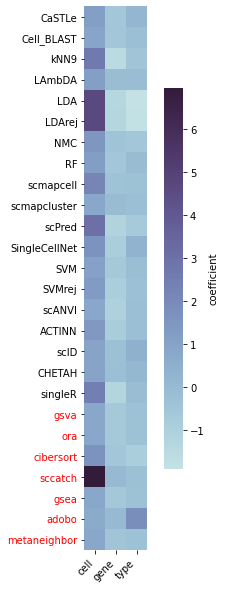

In [15]:
f, ax = plt.subplots(1, 1, figsize=(6,10))

#cbar_ax = f.add_axes([.905, .3, .05, .3])
colour = sns.cubehelix_palette(start=.5, rot=-.4, reverse=False, as_cmap=True)

sns.heatmap(df_coef, cmap=colour, square=True, annot=False, 
            cbar_kws={'label': "coefficient", "shrink": .7})
ax.set_xticklabels(df_coef.columns.values, rotation = 45, ha="right")

axc = ['black' for i in range(19)]+['red' for i in range(7)]
for ytick, col in zip(ax.get_yticklabels(), axc):
    ytick.set_color(col)
#ax.title.set_text('Running time by No. of cells')
plt.savefig("Heatmap_coef.png", bbox_inches='tight', dpi=600)
#plt.show()

In [16]:
df_coef.to_csv('df_coef.tsv', sep='\t')